In [ ]:
pip install awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.18.1
    Uninstalling docutils-0.18.1:
      Successfully uninstalled docutils-0.18.1


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
!mkdir -p /content/chest_xray/

In [ ]:
# Download dataset from S3
!aws s3 cp s3://x-raysbucket/chest_xray/ /content/chest_xray/ --recursive --no-sign-request

Streaming output truncated to the last 5000 lines.
download: s3://x-raysbucket/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg to chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg
download: s3://x-raysbucket/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg to chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg
download: s3://x-raysbucket/chest_xray/train/NORMAL/IM-0438-0001.jpeg to chest_xray/train/NORMAL/IM-0438-0001.jpeg
download: s3://x-raysbucket/chest_xray/train/NORMAL/IM-0437-0001.jpeg to chest_xray/train/NORMAL/IM-0437-0001.jpeg
download: s3://x-raysbucket/chest_xray/train/NORMAL/IM-0433-0001.jpeg to chest_xray/train/NORMAL/IM-0433-0001.jpeg
download: s3://x-raysbucket/chest_xray/train/NORMAL/IM-0440-0001.jpeg to chest_xray/train/NORMAL/IM-0440-0001.jpeg
download: s3://x-raysbucket/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg to chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg
download: s3://x-raysbucket/chest_xray/train/NORMAL/IM-0439-0001.jpeg to chest_xray/train/NORMAL/IM-0439-0001.jpeg

In [ ]:
# Download ResNet50(pre-trained CNN on ImageNet, great for image classification)
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Unfreeze last 20 layers of ResNet50
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Add classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # This reduces the 7x7x2048 output to 2048
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)  # Add a dense layer to help with feature processing
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
x = Dense(1, activation='sigmoid')(x)  # Final layer for binary classification

In [ ]:
model = Model(inputs=base_model.input, outputs=x)

# Compile with reduced learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']

)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Updated data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Reduced rotation
    width_shift_range=0.1,  # Reduced shift range
    height_shift_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Use class weights if needed
class_weight = {0: 1.0, 1: 1.5}  # Adjust based on class imbalance analysis


In [ ]:
# Load the data
train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    '/content/chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    '/content/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


326/326 ━━━━━━━━━━━━━━━━━━━━ 191s 382ms/step - accuracy: 0.7614 - loss: 0.6062 - val_accuracy: 0.5000 - val_loss: 2.7118 - learning_rate: 1.0000e-05
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.7118 - learning_rate: 1.0000e-05
Epoch 3/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 160s 349ms/step - accuracy: 0.9488 - loss: 0.1935 - val_accuracy: 0.5000 - val_loss: 2.5282 - learning_rate: 1.0000e-05
Epoch 4/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.5282 - learning_rate: 1.0000e-05
Epoch 5/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 141s 348ms/step - accuracy: 0.9626 - loss: 0.1371 - val_accuracy: 0.5000 - val_loss: 2.3585 - learning_rate: 1.0000e-05
Epoch 6/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.3585 - learning_rate: 1.0000e-05
Epoch 7/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 125s 376ms/step - accuracy: 0.9658 - loss: 0.1179 - val_accuracy: 0.5625 - val_loss: 1.3033 - learning_rate: 1.0000e-05
Epoch 8/20
326/326 ━━━━━━━━━━━━━━

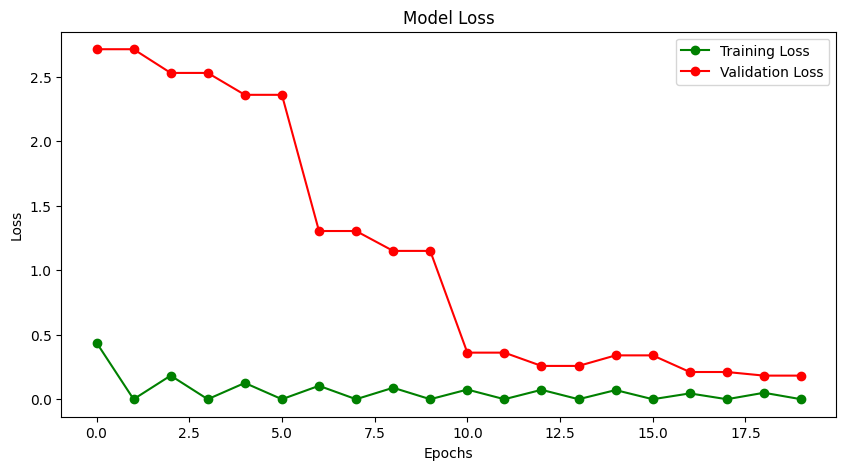

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], 'go-', label="Training Loss")
plt.plot(history.history['val_loss'], 'ro-', label="Validation Loss")
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

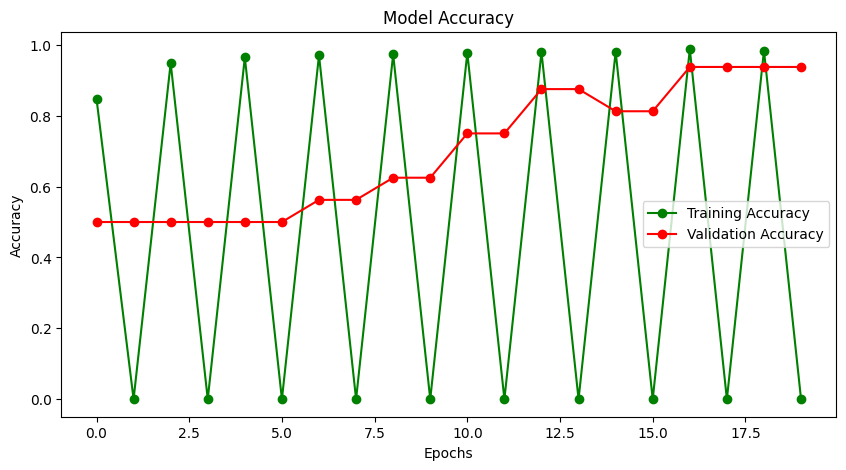

In [20]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], 'go-', label="Training Accuracy")
plt.plot(history.history['val_accuracy'], 'ro-', label="Validation Accuracy")
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('pneumonia_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
import os
# test the model all images in /content/chest_xray/test and get the predictions of each image
# Get the list of image files in the test directory
test_dir = '/content/chest_xray/test'
for root, dirs, files in os.walk(test_dir):
  for file in files:
    if file.endswith(('.jpg', '.jpeg', '.png')):
      test_image_path = os.path.join(root, file)
      # Load and preprocess the image
      img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(224, 224))
      img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.
      img_array = np.expand_dims(img_array, axis=0)

      # Make the prediction
      prediction = model.predict(img_array)
      confidence = float(prediction[0][0])
      result = "Pneumonia" if confidence > 0.5 else "Normal"

      # Print the results
      print(f"Image: {test_image_path}")
      print(f"Prediction: {result} (confidence: {confidence:.2%})")
      print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Image: /content/chest_xray/test/NORMAL/IM-0023-0001.jpeg
Prediction: Normal (confidence: 0.03%)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image: /content/chest_xray/test/NORMAL/NORMAL2-IM-0327-0001.jpeg
Prediction: Normal (confidence: 32.14%)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: /content/chest_xray/test/NORMAL/NORMAL2-IM-0325-0001.jpeg
Prediction: Normal (confidence: 4.09%)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: /content/chest_xray/test/NORMAL/IM-0073-0001.jpeg
Prediction: Normal (confidence: 30.39%)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: /content/chest_xray/test/NORMAL/IM-0027-0001.jpeg
Prediction: Normal (confidence: 0.01%)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: /content/chest_xray/test/NORMAL/NORMAL2-IM-0300-0001.jpeg
Prediction: Normal (confidence: 0.14%)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: /content/chest_xray/test/NORMAL/NORMAL2-IM-0139-0001.jpeg
Prediction: Normal (confidence: 29.85%)
---
1

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true labels and predictions
test_generator.reset()  # Ensure the generator is at the start
Y_true = test_generator.classes  # True labels
Y_pred = (model.predict(test_generator) > 0.5).astype("int32")  # Predictions rounded to 0 or 1

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(Y_true, Y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 722ms/step
Confusion Matrix:
[[175  59]
 [  3 176]]
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.75      0.85       234
   PNEUMONIA       0.75      0.98      0.85       179

    accuracy                           0.85       413
   macro avg       0.87      0.87      0.85       413
weighted avg       0.88      0.85      0.85       413



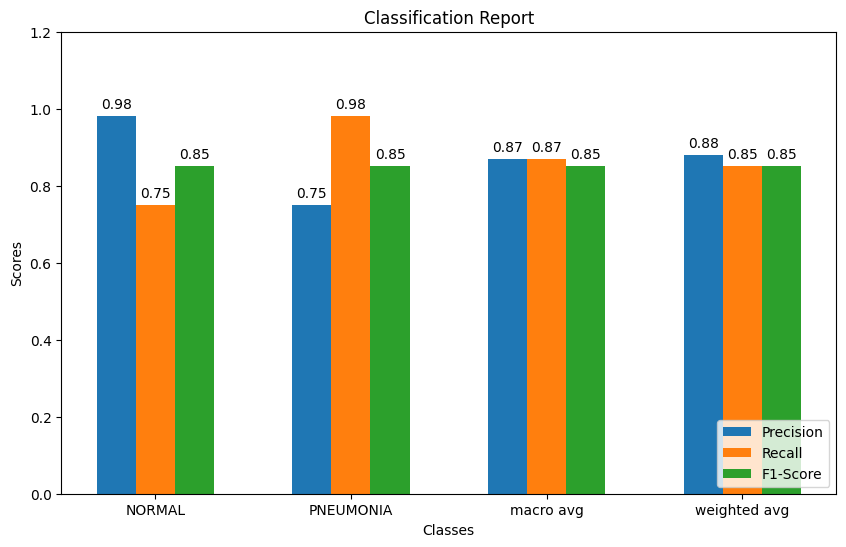

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming this is the output of the classification report from the model
report = {
    'NORMAL': {'precision': 0.98, 'recall': 0.75, 'f1-score': 0.85, 'support': 234},
    'PNEUMONIA': {'precision': 0.75, 'recall': 0.98, 'f1-score': 0.85, 'support': 179},
    'accuracy': 0.85,
    'macro avg': {'precision': 0.87, 'recall': 0.87, 'f1-score': 0.85, 'support': 413},
    'weighted avg': {'precision': 0.88, 'recall': 0.85, 'f1-score': 0.85, 'support': 413}
}

# Prepare data for visualization
labels = ['NORMAL', 'PNEUMONIA', 'macro avg', 'weighted avg']
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]
support = [report[label]['support'] for label in labels]

# Plot the classification report
x = np.arange(len(labels))
width = 0.2  # Width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

# Adding text for labels, title, and custom x-axis tick labels, etc.
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report')
plt.xticks(x, labels)
plt.legend(loc='lower right')

# Displaying values above the bars for better readability
for i in range(len(labels)):
    plt.text(i - width, precision[i] + 0.02, f"{precision[i]:.2f}", ha='center')
    plt.text(i, recall[i] + 0.02, f"{recall[i]:.2f}", ha='center')
    plt.text(i + width, f1_score[i] + 0.02, f"{f1_score[i]:.2f}", ha='center')

plt.ylim([0, 1.2])  # Extend y-axis limit for better text display
plt.show()

### Classification Report Analysis
- **Precision for NORMAL (0.98)**: When the model predicts "NORMAL," it is correct 98% of the time. This high precision for "NORMAL" shows that if the model identifies an image as "NORMAL," it’s highly likely to be correct.
- **Recall for NORMAL (0.75)**: Out of all actual "NORMAL" images, the model correctly identifies 75%. The lower recall for "NORMAL" indicates that the model is missing some true "NORMAL" cases, likely because it’s biased toward predicting "PNEUMONIA."
- **Precision for PNEUMONIA (0.75)**: When the model predicts "PNEUMONIA," it is correct 75% of the time. This lower precision shows that there are some false positives in the "PNEUMONIA" class.
- **Recall for PNEUMONIA (0.98)**: Out of all actual "PNEUMONIA" cases, the model correctly identifies 98%. This very high recall means the model is effective at catching nearly all pneumonia cases, which is beneficial for medical diagnostics.

- **Overall Accuracy (0.85)**: The model correctly classifies 85% of the images, which is solid but could be improved by addressing the model’s tendency to misclassify "NORMAL" cases as "PNEUMONIA."

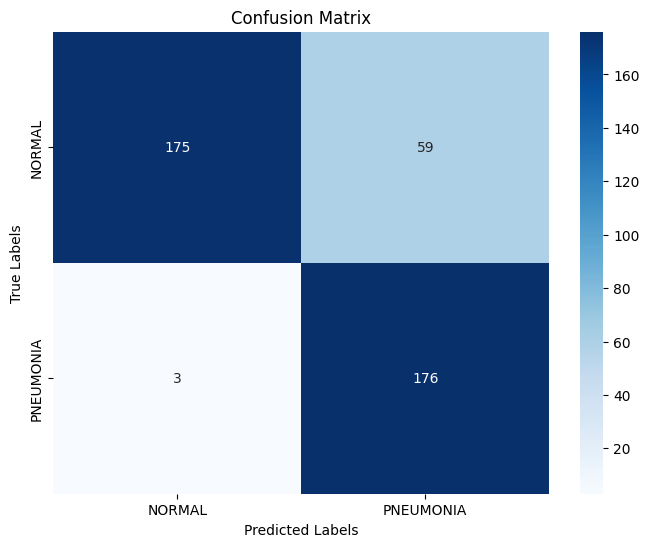

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

- **True Negatives (TN)**: 175 images that were truly "NORMAL" and correctly classified as "NORMAL."
- **False Positives (FP)**: 59 images that were truly "NORMAL" but incorrectly classified as "PNEUMONIA."
- **False Negatives (FN)**: 3 images that were truly "PNEUMONIA" but incorrectly classified as "NORMAL."
- **True Positives (TP)**: 176 images that were truly "PNEUMONIA" and correctly classified as "PNEUMONIA."

### Confusion Matrix Analysis
- **Few False Negatives**: Only 3 "PNEUMONIA" cases were misclassified as "NORMAL," meaning the model has high recall for "PNEUMONIA," which is critical in medical applications where missing a positive diagnosis can have serious consequences.
- **Higher False Positives**: 59 "NORMAL" images were misclassified as "PNEUMONIA," indicating that the model is more prone to over-predicting pneumonia, possibly to prioritize sensitivity over specificity.


In [23]:
import os
import tensorflow as tf

misclassified = []
confidence_scores = []

# Loop through test images
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            test_image_path = os.path.join(root, file)
            img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.
            img_array = np.expand_dims(img_array, axis=0)

            # Make the prediction
            prediction = model.predict(img_array)
            confidence = float(prediction[0][0])
            result = "Pneumonia" if confidence > 0.5 else "Normal"
            true_label = "Pneumonia" if "PNEUMONIA" in test_image_path else "Normal"

            # Collect misclassified images and confidence scores
            if result != true_label:
                misclassified.append((test_image_path, true_label, result, confidence))

# Display misclassified samples
for image_path, true_label, predicted_label, confidence in misclassified[:10]:  # Show up to 10 examples
    print(f"Image: {image_path}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label} (confidence: {confidence:.2%})")
    print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━